## 2a. Calculate closed-system degassing path assuming melt composition is the bulk composition (with and without sulfur saturation)

## Setting things up
You need to install VolFe once on your machine, if you haven't yet. Then we need to import a few Python packages (including VolFe). 

In [1]:
# Install VolFe on your machine. Don't remove the # from this line!
# pip install VolFe # Remove the first # in this line if you have not installed VolFe on your machine before.

# import python packages
import pandas as pd
import matplotlib.pyplot as plt
import VolFe as vf

At a minimum to run a degassing calculation, we need a dataframe of the melt composition, an estimate of oxygen fugacity and Fe in the melt [note 1], and temperature at some point along the degassing path:

- Sample is just the name for this analysis.

- Temperature is in 'C.

- Volatile-free melt composition is in wt% oxides [note 2]. All these oxides must be present in the dataframe, so set them to 0. if you have no data for them (although see [note 1] around FeOT).

- H2O is all hydrogen in the melt reported as H2O in wt% [note 3]. 

- CO2ppm is all carbon in the melt reported as CO2 in ppm [note 3].

- STppm is all sulfur in the melt reported as S in ppm [note 3].

- Xppm is all "X" in the melt reported as X in ppm [note 3]. X is an unreactive melt species whose identity can be changed - this is explored in Example 2e.

- Fe3+FeT is the ratio of Fe3+ to FeT in the melt.

[note 1] In this example we specify oxygen fugacity using Fe3+/FeT and Fe in the melt as FeOT as is quite common for melt inclusion and matrix glass analyses - other options are possible, see Example 1a for more information.

[note 2] It does not matter what the non-volatile oxides sum too - they are renormalised to 100 wt% minus the total of the volatiles (i.e., H2O + CO2 + ST + X).

[note 3] The volatile concentrations are absolute for the melt = i.e., the non-volatile melt composition is normalised to 100 wt% minus the volatiles. The volatiles are not added to the oxides and then renormalised.

The following composition is analysis Sari15-04-33 from Brounce et al. (2014), with a temperature chosen as 1200 'C.

In [2]:
# Define the melt composition, fO2 estimate, and T as a dictionary.
my_analysis = {'Sample':'Sari15-04-33',
           'T_C': 1200., # Temperature in 'C
           'SiO2': 47.89, # wt%
           'TiO2': 0.75, # wt%
           'Al2O3': 16.74, # wt%
           'FeOT': 9.43, # wt%
           'MnO': 0.18, # wt%
           'MgO': 5.92, # wt%
           'CaO': 11.58, # wt%
           'Na2O': 2.14, # wt%
           'K2O': 0.63, # wt%
           'P2O5': 0.17, # wt%
           'H2O': 4.17, # wt%
           'CO2ppm': 1487., # ppm
           'STppm': 1343.5, # ppm
           'Xppm': 0., # ppm
           'Fe3FeT': 0.195}

# Turn the dictionary into a pandas dataframe, setting the index to 0.
my_analysis = pd.DataFrame(my_analysis, index=[0])

For this example we will mostly use the default options in VolFe, which can be found below:

In [3]:
# print default options in VolFe
print(vf.default_models)

                            option
type                              
COH_species     yes_H2_CO_CH4_melt
H2S_m                         True
species X                       Ar
Hspeciation                   none
fO2                       Kress91A
...                            ...
error                          0.1
print status                 False
output csv                    True
setup                        False
high precision               False

[78 rows x 1 columns]


But I'll just highlight the specific options that are important to the degassing calculation and what their default values are:

**bulk_composition = melt-only** This means the composition (including volatiles and fO2 estimate) represent the bulk composition of the system - there is only melt present and all volatiles are dissolved in the melt.

**starting_P = Pvsat** This means the calculation will start at Pvsat for the composition given.

**gasssing_style = closed** This means the melt and vapor remain in chemical equilibrium throughout and the bulk composition is constant during the calculation

**gassing_direction = degas** This means pressure will decrease during the calculations and therefore the melt will degas.

The default pressure step is 10 bars, which works most of the time but can be a little slow.
Increasing the step size will speed up the calculation but if the step size is too big it will struggle to solve because it uses the previous step for its initial guesses.

In [4]:
degas1 = vf.calc_gassing(my_analysis)

We could run the same calculation from a csv file if we preferred.

We'll use the examples_marianas_wT csv in files and use all the default options again. 
The data in this file are from Brounce et al. (2014, 2016) and Kelley & Cottrell (2012).
Sari15-04-33 is row 48 in that file. 

Uncomment the lines to use them (i.e., remove the # at the start of each line).

In [5]:
# read the csv file 
# my_analyses = pd.read_csv("../files/example_marianas.csv") # remove first # in this line to run it

# run degassing calculation for row 48 - Sari15-04-33
# vf.calc_gassing(my_analyses,row=48) # remove first # in this line to run it

Turns out the melt was sulfide-saturated during the degassing path. 
Under those conditions, the results for the melt and vapor are metastable with respect to saturation of sulfide.

We can run the same calculation, but instead limit the sulfur content in the melt to sulfide or anhydrite saturation, if it reaches the limit. 
To do that we change the "sulfur_saturation" option from "False" (sulfur phases cannot saturate) to "True" (sulfur phases can saturate if the sulfur content is high enough).

In [6]:
# Choose the options I want to change for the calculation - everything else will use the default options
my_models = [['sulfur_saturation','True']]

# turn to dataframe with correct column headers and indexes    
my_models = vf.make_df_and_add_model_defaults(my_models)

And then we run the degassing calculation with those model options

In [7]:
degas2 = vf.calc_gassing(my_analysis, models=my_models)

And below we can plot the two results to see the difference.

The black solid curves are the first calculation (not allowing sulfur to saturate), whilst the black dotted curves are the second calculation (sulfur can saturate as sulfide or anhydrite if the concentration in the melt is high enough).

It has no effect on the H2O or CO2 contents of the melt, but the sulfur content is much less at the start of degassing because it is in a sulfide phase instead!

(4000.0, 0.0)

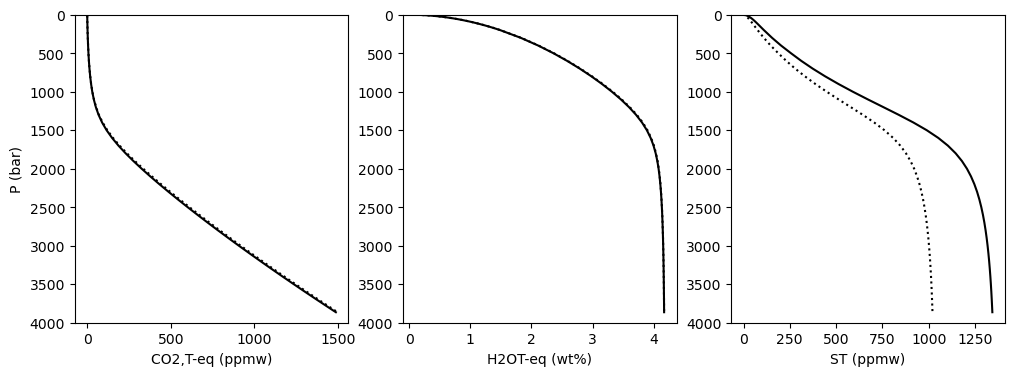

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

data1 = degas1 # sulfur cannot saturate
data2 = degas2 # sulfur can saturate

# Plotting results
ax1.plot(data1['CO2T-eq_ppmw'], data1['P_bar'], '-k')
ax1.plot(data2['CO2T-eq_ppmw'], data2['P_bar'], ':k')
ax2.plot(data1['H2OT-eq_wtpc'], data1['P_bar'], '-k')
ax2.plot(data2['H2OT-eq_wtpc'], data2['P_bar'], ':k')
ax3.plot(data1['ST_ppmw'], data1['P_bar'], '-k')
ax3.plot(data2['ST_ppmw'], data2['P_bar'], ':k')

ax1.set_ylabel('P (bar)')
ax1.set_xlabel('CO2,T-eq (ppmw)')
ax2.set_xlabel('H2OT-eq (wt%)')
ax3.set_xlabel('ST (ppmw)')
ax1.set_ylim([4000,0])
ax2.set_ylim([4000,0])
ax3.set_ylim([4000,0])